In [1]:
#This is a walkthrough of analysis and model selection for a housing dataset.
#Due to scraping being temporarily unavailable for reasons mentioned,I decided to use 
#a dataset that would be quite similar to the one I would have scraped online. 
# I hope this is a satisfactory explanation for the project walkthrough, as well 
#as hopefully serving as a basic idea of what we can do using this as a base.

In [2]:
#Loading Libraries and the data 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
import xgboost as xgb
import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [3]:
#Loading train and test sets

train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
#Dropping ID, Alley,Land Contour,Fence,MiscVal columns since they don't have predictive value for our case
train.drop("Id",axis =1, inplace=True)
test.drop("Id",axis =1, inplace=True)

In [6]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
#At this point it's customary to analyze the target variable, Sale Price. 
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


 mu = 180921.20 and sigma = 79415.29



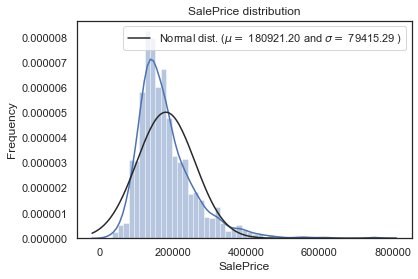

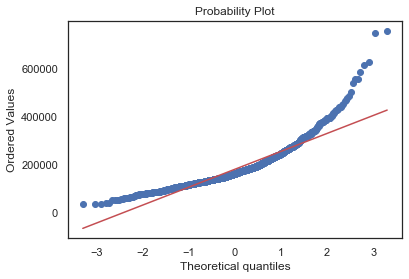

Skewness: 1.882876
Kurtosis: 6.536282


In [9]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [10]:
#From the plot above, there seems to be a certain skewness that tells that the 
#sale prices deviate from the normal dist. We'll have to transform the data so that 
#it's as close to a normal distribution as possible(due to our assumptions in the models later on)


In [11]:
#Listing the numerical features present in the data

train.select_dtypes(include=['int64', 'float']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

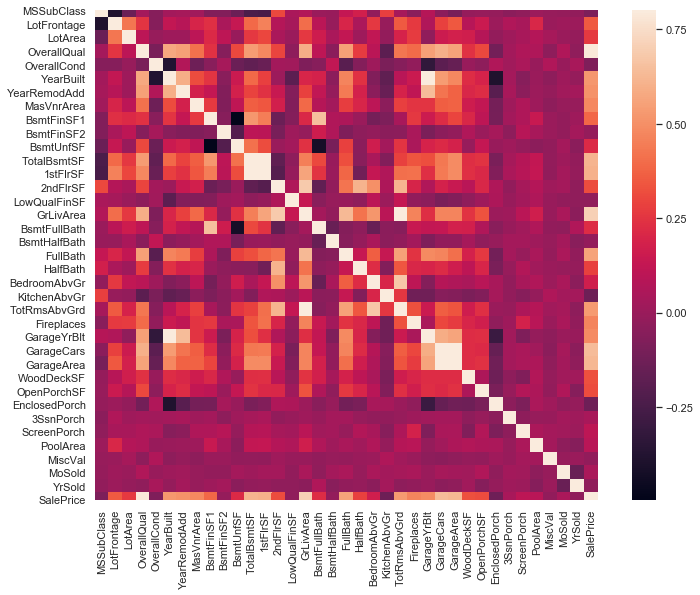

In [12]:
# We can check which features are most related to the house prices using the 
#correlation matrix. 

cor_mat=train.corr()
f,ax=plt.subplots(figsize=(12,9))
sns.heatmap(cor_mat,vmax=0.8, square=True);

In [17]:
# As the legend on the right side says, the darker boxes mean little to no correlation,
#while the lighter boxes mean statistically significant correlation.
# We can choose the  top few features that are the most correlated to sale price.





k=11
cols=cor_mat.nlargest(k,'SalePrice')['SalePrice'].index
#cm = np.corrcoef(train[cols.values.T])
#sns.set(font_scale=1.25)
#hm= sns.heatmap(cm, cbar=True,annot=True,square=True, fmt='.2f',annot_kws={'size':10},
        #       yticklabels=cols.values, xticklabels=cols.values)
#plt.show()

In [18]:
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,SalePrice
1,OverallQual
2,GrLivArea
3,GarageCars
4,GarageArea
5,TotalBsmtSF
6,1stFlrSF
7,FullBath
8,TotRmsAbvGrd
9,YearBuilt


In [19]:
#Most correlated is Sale Price, but ignoring that, we see that there are 
#factors like OverallQual, GrLivArea, garages etc that are the 10 most correlated
#features to Sale PRice in this dataset.

#Let's go over each feature and try to see if they're in need of some prepreocessing

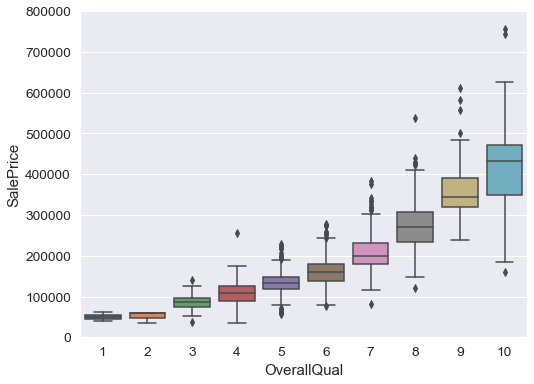

In [20]:
# Overall Quality vs Sale Price
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

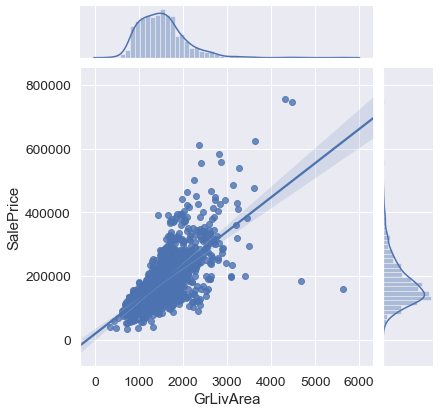

In [21]:
# Living Area vs Sale Price
sns.jointplot(x=train['GrLivArea'], y=train['SalePrice'], kind='reg')

In [22]:
#More living area== more price. Fair enough. There are some outliers,
#but we can remove them. 
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index).reset_index(drop=True)

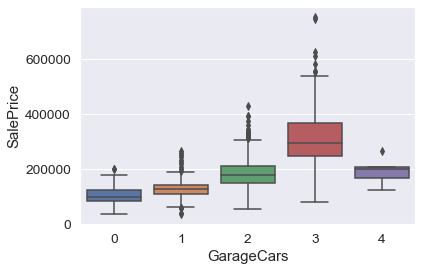

In [23]:
# Garage Area vs Sale Price
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

In [24]:
#Against common logic, 4 car garage costs less than a 3 car garage. This will
#definitely mess up the model, so I'll be manually removing this as well.
train = train.drop(train[(train['GarageCars']>3) & (train['SalePrice']<300000)].index).reset_index(drop=True)

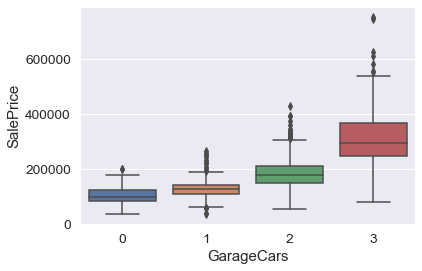

In [25]:
#Visualizing again
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

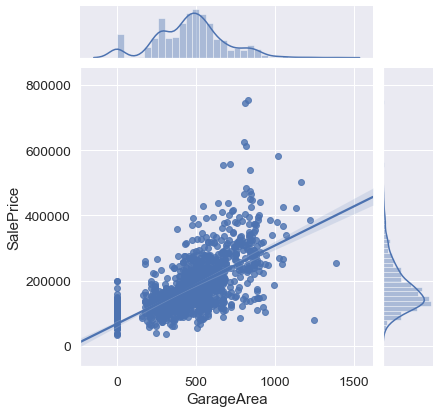

In [26]:
# Garage Area vs Sale Price
sns.jointplot(x=train['GarageArea'], y=train['SalePrice'], kind='reg')

In [27]:
#Removing the outliers!(> 1000 sqft, <$300K) 

train = train.drop(train[(train['GarageArea']>1000) & (train['SalePrice']<300000)].index).reset_index(drop=True)

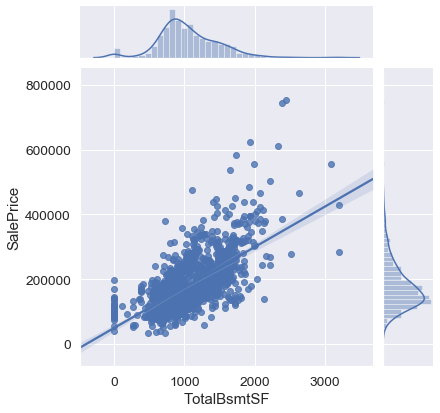

In [28]:
# Basement Area vs Sale Price
sns.jointplot(x=train['TotalBsmtSF'], y=train['SalePrice'], kind='reg')

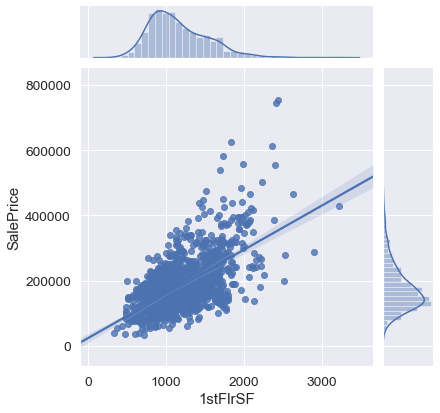

In [29]:
# First Floor Area vs Sale Price
sns.jointplot(x=train['1stFlrSF'], y=train['SalePrice'], kind='reg')

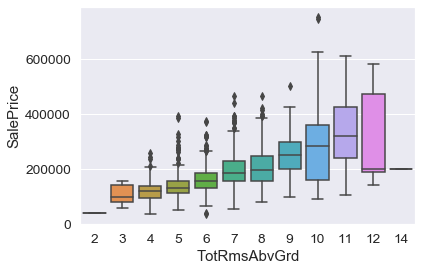

In [30]:
# Total Rooms vs Sale Price
sns.boxplot(x=train['TotRmsAbvGrd'], y=train['SalePrice'])

In [31]:
#Houses with >11 rooms are somehow cheaper. This could be true in certain conditions,
#so, I'll keep it in. 



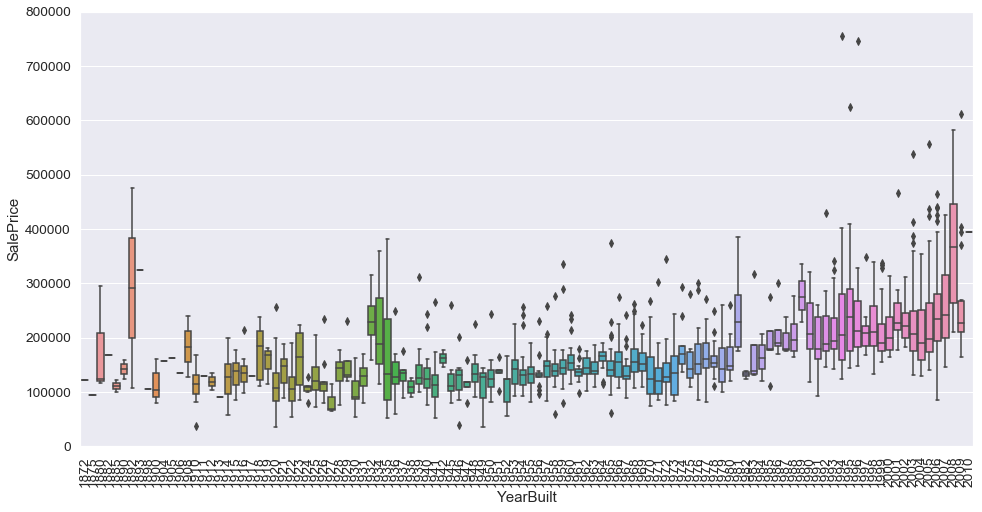

In [32]:
# Year Built vs Sale Price
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

In [33]:
#Handling Missing data

In [34]:
# Combining Datasets
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("Train data size is : {}".format(train.shape))
print("Test data size is : {}".format(test.shape))
print("Combined dataset size is : {}".format(all_data.shape))

Train data size is : (1448, 80)
Test data size is : (1459, 79)
Combined dataset size is : (2907, 79)


In [35]:
# Find Missing Ratio of Dataset
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
PoolQC,99.690402
MiscFeature,96.422429
Alley,93.223254
Fence,80.392157
FireplaceQu,48.710010
LotFrontage,16.683867
GarageQual,5.469556
GarageCond,5.469556
GarageFinish,5.469556
GarageYrBlt,5.469556


Text(0.5, 1.0, 'Percent missing data by feature')

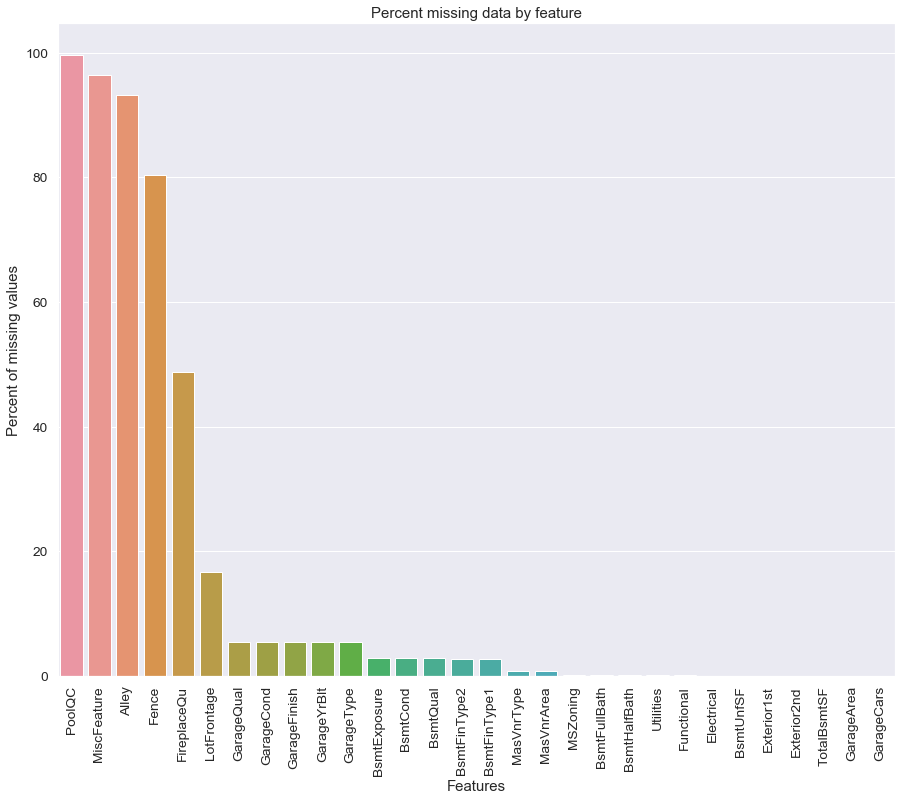

In [36]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [37]:
#Imputing missing values.There is a data description file given for this dataset,
#which I will be attaching along with this notebook for review.

#PoolQC : data description says NA means "No Pool"
#MiscFeature : data description says NA means "no misc feature"
#Alley : data description says NA means "no alley access"
#Fence : data description says NA means "no fence"
#FireplaceQu : data description says NA means "no fireplace"
#LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
#GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with "None".
#GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0.
#BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath: Replacing missing data with 0.
#BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there isn't a basement.
#MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
#MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'.
#Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
#Functional : data description says NA means typical.
#Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
#KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
#Exterior1st and Exterior2nd : Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
#SaleType : Fill in again with most frequent which is "WD"
#MSSubClass : Na most likely means No building class. We can replace missing values with None

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")




In [38]:
# Checking if there are any missing values left
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [39]:
#There are some features that could, with their given values, mislead the model
# and represent something else entirely. For example, MSSubClass identifies the type of 
#house .

all_data['MSSubClass'].describe()

count    2907.000000
mean       57.094943
std        42.510238
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64

In [40]:
#The values here are actually categories instead of values. 

#MSSubClass =The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [41]:
#Taking a look at KitchenQuality as a feature

all_data['KitchenQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [42]:
#These are again categorical values,and can be assigned numbersbased on increasing quality
#given in the data description file. 

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# Process columns and apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# Check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2907, 78)


In [43]:
#There's a few features that themselves mean less than they would being a part of something bigger.
#One is square footage.

# Adding Total Square Feet feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']


 mu = 12.02 and sigma = 0.40



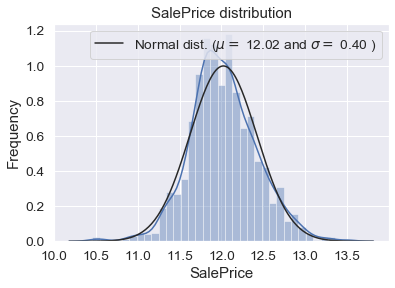

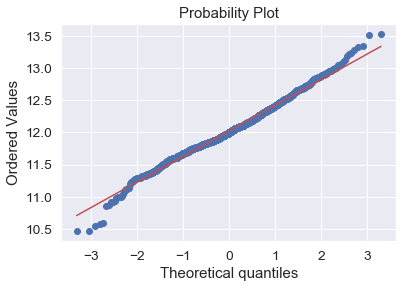

Skewness: 0.130172
Kurtosis: 0.822862


In [44]:
#Now I have to fix the skewness from earlier to make the distribution as close to normal
#as possible.For that I use the numpy fuction log1p which  applies log(1+x) to all elements of the column


train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

y_train = train.SalePrice.values

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

In [45]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness.head()

,Skewed Features
MiscVal,21.911765
PoolArea,17.658029
LotArea,13.147728
LowQualFinSF,12.063406
3SsnPorch,11.352135


In [46]:
skewness = skewness[abs(skewness) > 0.75]
print(" {} skewed numerical features to transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1

 59 skewed numerical features to transform


In [47]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2907, 220)


In [48]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [49]:
#Modelling and predicting

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [50]:
# Cross-validation with k-folds
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [51]:
#For my models I'll be using the following. I used all these to best compare the ideal model for this case:

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1,
                             random_state =7)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)






In [52]:
#Checking performance of base models by evaluating the cross-validation RMSLE error.

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1111 (0.0071)

ElasticNet score: 0.1111 (0.0072)

Kernel Ridge score: 0.1148 (0.0075)

Gradient Boosting score: 0.1173 (0.0079)

Xgboost score: 0.1187 (0.0072)

LGBM score: 0.1163 (0.0060)



In [54]:
#Stacking the models to average their scores...

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [55]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1085 (0.0073)



In [56]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [57]:
#Since the lasso model performed the best, I'll use it as the meta

stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1077 (0.0070)


In [58]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [59]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07831301732161669


In [60]:
#XGBOOST model

model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))


0.04223766987300638


In [61]:
#LightGBM model


model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))




0.07186432170947024


In [62]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.10 + lgb_train_pred*0.20 ))

RMSLE score on train data:
0.07155011612288205


In [63]:
#Ensemble Prediction:
#To get the weights of each model, let's take the inverse of each regressor and average it out of 100%
Stacked = 1/(0.1077)
XGBoost = 1/(0.1187)
LGBM = 1/(0.1163)
Sum = Stacked + XGBoost + LGBM
Stacked = Stacked/Sum
XGBoost = XGBoost/Sum
LGBM = LGBM/Sum
print(Stacked, XGBoost, LGBM)


0.3529350255699257 0.3202283256434793 0.326836648786595


In [64]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*Stacked +
               xgb_train_pred*XGBoost + lgb_train_pred*LGBM))

RMSLE score on train data:
0.06177980524285943


In [65]:
ensemble = stacked_pred*Stacked + xgb_pred*XGBoost + lgb_pred*LGBM

In [ ]:
#That's the final model, which has an RMSLE score of 0.0617. It's an ensemble model
#as you see, and we can build upon this moving forward, trying different combinations
# and even seeing if we can build a Deep Learning model given we scrape a lot more data.